In [10]:
row_keys = ["subj", "act"]
expected_keys = ["subj", "act", "score", "eta", "#ex"]

In [11]:
def get_value_from(row, metric):
    if metric == 'seta':
        return 0.5* (get_value_from(row, 'score') + get_value_from(row, 'eta'))
    val = row[expected_keys.index(metric)]
    #if metric == 'eta':
        # convert eta from [0,1] to [-1,1]
        #return (float(val) - 0.5)*2
    try:
        f=float(val)
        return f
    except:
        return val
    

In [12]:
def read_tsv(filename: str):
    key_row_map = {}
    with open(filename, "r") as input_fp:
        for line in input_fp:
            fields = line.strip().split("\t")
            if len(fields) < len(expected_keys) or (fields[0] == 'subj' and fields[-1] == '#ex'):
                # hack to detect non-tsv lines
                continue
            key = "\t".join([get_value_from(fields, metric) for metric in row_keys])
            key_row_map[key] = fields
    return key_row_map

In [13]:
def get_agg_metric(key_rows, agg_key, agg_metric, agg_func, key_filter=None):
    all_results = {}
    for key, row in key_rows.items():
        curr_key = key.split("\t")[row_keys.index(agg_key)]
        if key_filter is not None and not key_filter(key):
            continue
        if curr_key not in all_results:
            all_results[curr_key] = []
        value = get_value_from(row, agg_metric)
        all_results[curr_key].append(value)
    agg_results = {}
    for key, results in all_results.items():
        agg_results[key] = agg_func(results)
    
    return agg_results
            

In [14]:
from os import path
x_keys = {'distilbert': 'BERT_Dist', 'bertbase': 'BERT_B', 'robertabase': 'RoBERTa_B', 'bertlarge': 'BERT_L', 'robertalarge': 'RoBERTa_L'}

models = ['distilbert', 'bertbase', 'bertlarge', 'robertabase', 'robertalarge']

from matplotlib import cm
some_colors = cm.get_cmap('plasma', len(x_keys)+1)
bar_color_map = {
    "distilbert": some_colors.colors[4],
    "bertbase": some_colors.colors[3],
    "robertabase": some_colors.colors[2],
    "bertlarge": some_colors.colors[1], 
    "robertalarge": some_colors.colors[0]
}

pattern_map = {
    "distilbert": "xx",
    "bertbase": "..",
    "robertabase": "//",
    "bertlarge": "--", 
    "robertalarge": "\\\\"
}

   
def load_scores(models, metric, agg_key, domain, agg_inner, agg_outer):
    scores = {}
    for f in models:
        filename="../data/{}_{}.analysis.txt".format(f, domain)
        if not path.exists(filename):
            filename="../data/{}_{}.log.txt".format(f, domain) 
        key_rows = read_tsv(filename)
        agg_metric_per_key = get_agg_metric(key_rows, agg_key, metric, agg_inner, key_filter=None)

        s = agg_outer([p for p in agg_metric_per_key.values()])
        scores[f] = s
    return scores

In [15]:
max_abs_lambda = lambda arr: max([abs(x) for x in arr])
avg_abs_lambda = lambda arr: sum([abs(x) for x in arr]) / len(arr)
margin_lambda = lambda arr: (max(arr) - min(arr))/2
avg_lambda = lambda arr: sum([x for x in arr]) / len(arr)
min_abs_lambda = lambda arr: min([abs(x) for x in arr])
sum_abs_lambda = lambda arr: sum([abs(x) for x in arr])
var_lambda = lambda arr: sum([x*x for x in arr]) / len(arr)
avg_pos_lambda = lambda arr: sum([x for x in arr if x > 0]) / len(arr)

import numpy as np
std_lambda = lambda arr: np.std(arr)
# relative standard deviation
rsd_lambda = lambda arr: np.std(arr) / np.mean(arr)

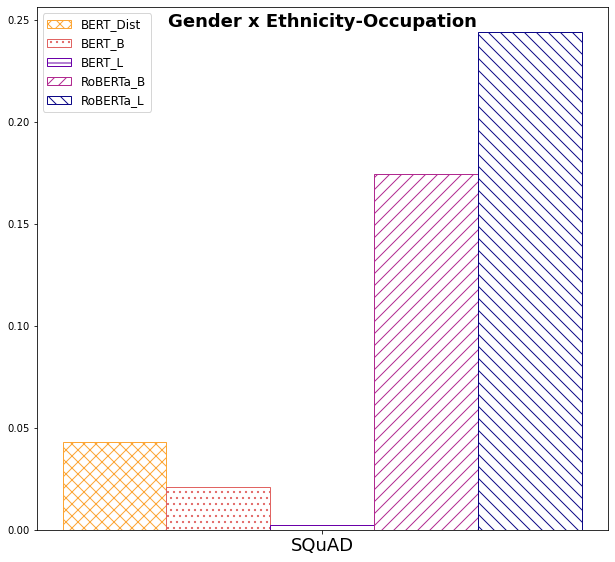

In [16]:
def plot_models(models, metric="score", agg_key="act", domain="gender", agg_inner=avg_abs_lambda, agg_outer=avg_abs_lambda, x_keys=x_keys, title="NA", legend=True):
    # make the bars appear in desired order
    if x_keys is None:
        x_keys = {k:k for k in models}
        
    import matplotlib.pyplot as plt
    squad_scores = load_scores(models, metric, agg_key, domain, agg_inner, agg_outer)
    squad_scores = [squad_scores[f] for f in models]
    #newsqa_scores = load_scores(['newsqa_'+p for p in models], metric, agg_key, domain, agg_inner, agg_outer)
    #newsqa_scores = [newsqa_scores[f] for f in ['newsqa_'+p for p in models]]
    #lm_scores = load_scores(models, metric, agg_key, 'lm_'+domain, agg_inner, agg_outer)
    #lm_scores = [lm_scores[f] for f in models]
    
    #all_scores = np.asarray([squad_scores, newsqa_scores, lm_scores])
    all_scores = np.asarray([squad_scores])
    assert(all_scores.shape == (1, 5))
    bar_width = 0.1
    index = np.arange(all_scores.shape[0])
    for j in range(all_scores.shape[1]):
        f = models[j]
        plt.bar(bar_width*j+index, all_scores[:,j], width=bar_width, color="white", edgecolor=bar_color_map[f], hatch=pattern_map[f], label=x_keys[f])
    
    plt.title(title, fontsize=18, fontweight="bold", x=0.5, y=0.95)
    plt.xticks(index + bar_width*2, tuple(['SQuAD']), fontsize=18)
    if legend:
        plt.legend(prop={'size': 12})
    plt.tight_layout()
    plt.gcf().set_size_inches((9, 9))

plot_models(models, "score", "subj", "gender_ethnicity", agg_inner=margin_lambda, agg_outer=avg_abs_lambda, 
               title='Gender x Ethnicity-Occupation')

In [17]:
#import matplotlib.pyplot as plt

#fig, _ = plt.subplots(2, 2, figsize = (20,8))
#plt.subplot(2, 2, 1)
#plot_models(models, "score", "subj", "gender_ethnicity", agg_inner=max_abs_lambda, agg_outer=avg_abs_lambda, 
#               title='Gender*Ethnicity-Occupation', legend=False)
#plt.subplot(2, 2, 2)
#plot_models(models, "score", "subj", "country", agg_inner=max_abs_lambda, agg_outer=avg_abs_lambda, 
#               title='Nationality', legend=False)
#plt.subplot(2, 2, 3)
#plot_models(models, "score", "subj", "ethnicity", agg_inner=max_abs_lambda, agg_outer=avg_abs_lambda, 
#               title='Ethnicity', legend=False)
#plt.subplot(2, 2, 4)
#plot_models(models, "score", "subj", "religion", agg_inner=max_abs_lambda, agg_outer=avg_abs_lambda, 
#               title='Religion', legend=False)
#fig.legend(labels=[x_keys[f] for f in models], fontsize=20, bbox_to_anchor=(0.5, 0.95),
#           loc='upper center', ncol=len(models), borderaxespad=0.25)
#plt.subplots_adjust(top=0.85)
#plt.show()

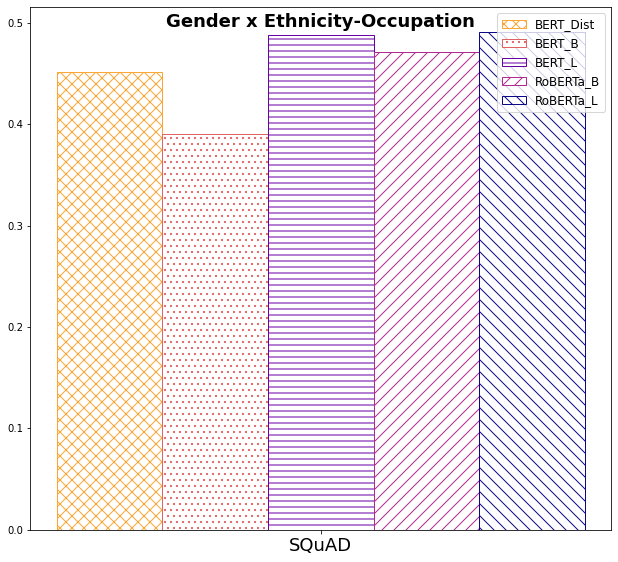

In [18]:
#fig, _ = plt.subplots(2, 2, figsize = (20,8))
#plt.subplot(2, 2, 1)
#plot_models(models, "eta", "subj", "gender", agg_inner=avg_abs_lambda, agg_outer=avg_abs_lambda, 
#               title='Gender-Occupation', legend=False)
#plt.subplot(2, 2, 2)
#plot_models(models, "eta", "subj", "country", agg_inner=avg_abs_lambda, agg_outer=avg_abs_lambda, 
#               title='Nationality', legend=False)
#plt.subplot(2, 2, 3)
#plot_models(models, "eta", "subj", "ethnicity", agg_inner=avg_abs_lambda, agg_outer=avg_abs_lambda, 
#               title='Ethnicity', legend=False)
#plt.subplot(2, 2, 4)
#plot_models(models, "eta", "subj", "religion", agg_inner=avg_abs_lambda, agg_outer=avg_abs_lambda, 
#               title='Religion', legend=False)
#fig.legend(labels=[x_keys[f] for f in models], fontsize=18, bbox_to_anchor=(0.5, 0.95),
#           loc='upper center', ncol=len(models), borderaxespad=0.25)
#plt.subplots_adjust(top=0.85)
#plt.show()
plot_models(models, "eta", "subj", "gender_ethnicity", agg_inner=avg_abs_lambda, agg_outer=avg_abs_lambda,
            title='Gender x Ethnicity-Occupation', legend=True)